In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)

from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
    KFold
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import ExtraTreesClassifier

from utils import multivariate_classifier

Using MNE with API > 0.19


In [4]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 12  # width in inches
fig_height = 9  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette
(nt_colors))

# Load Data

In [1]:
epoch_type = "evoked"
# epoch_type = 'pseudo-rs'

all_participants = [
    "VP07",
    "VP08",
    "VP09",
    "VP10",
    "VP11",
    "VP12",
    "VP13",
    "VP14",
    "VP18",
    "VP19",
    "VP20",
    "VP22",
    "VP23",
    "VP24",
    "VP25",
    "VP26",
    "VP27",
    "VP28",
    "VP29",
    "VP30",
    "VP31",
    "VP32",
    "VP33",
    "VP35",
    "VP36",
    "VP37",
]

path = "/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/"  # icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [5]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8',
           'p_e_1', 'p_e_2',  'p_e_4', 'p_e_8', 'k', 'se'
           ,'msf', 'sef90', 'sef95',
           'b', 'b_n', 'g','g_n', 't', 't_n', 
           'd', 'd_n', 'a_n', 'a', 
           'CNV', 'P1', 'P3a', 'P3b']

erps =['CNV', 'P1', 'P3a', 'P3b']
freqs = ['d','t','a', 'b','g']
freqs_n = ['d_n','t_n','a_n', 'b_n','g_n']
spectral_summary = ['msf', 'sef90', 'sef95']
spectral = freqs + freqs_n + spectral_summary
connectivity = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8',]
complexity = [ 'k','se','p_e_1', 'p_e_2','p_e_4', 'p_e_8',]

In [6]:
df = pd.DataFrame()

for i, v in enumerate(all_participants):
    participant = v

    folder = path + participant + "/"

    df_ = pd.read_csv(
        folder + participant + "_" + epoch_type + "_all_marker.csv", index_col=0
    )
    df_["participant"] = i
    df = df.append(df_)



In [7]:
df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df_markers
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial <= 4')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )

# df_markers.to_csv('Data/all_markers.csv')

In [63]:

def multivariate_classifier(
    data, label, features, model ,pca = False, n_components = 3,  cv_splits = 5,grid_search=False,plot = True, permutation=False, n_permutations = 1000 
):
    """
    data: dataframe with features and labels
    label: name of the column with the labels for the classification
    features: feaure or list of features corresponding to the columns of the data frame with the markers
    model: type of classifier model {SVM or forest}
    pca: if use pca as reduction
    n_components: number of components of the pca
    cv_splits: number of crossvalidations splits
    grid_search: if true it will apply grid search 5cv to find the best parameters of C and gamma, only for the SVM. Deafault: False
    n_permutations: number of permutations
    """
    #pipeline steps init
    steps = [("scaler", StandardScaler())]
    
    if pca == True:
        steps.append(('pca', PCA(n_components = n_components)))
        
    C= 0.001
    gamma=0.1
    
    y, lbl = pd.factorize(data[label])
    X = data[features].astype("float32").values
        
    if grid_search == True:
 

        steps_grid = steps.copy()
        steps_grid.append(("SVM", SVC(probability=True)))
        pipe_grid = Pipeline(steps_grid)

        parameteres = {
            "SVM__C": [0.001, 0.1, 10, 100, 10e5],
            "SVM__gamma": [1,0.5, 0.1, 0.01, 0.001],
        }
        
        grid = GridSearchCV(pipe_grid, param_grid=parameteres, cv=cv_splits, n_jobs=-1)
        grid.fit(X, y)
        
        print(grid.best_params_)
        
        C=grid.best_params_["SVM__C"]
        gamma=grid.best_params_["SVM__gamma"]
        
    if model == 'SVM':
        steps.append(('SVM', SVC(C = C, gamma = gamma, probability = True)))       

        pipe_cv = Pipeline(steps)

        cv = KFold(cv_splits, shuffle=True, random_state = 42)

        aucs = cross_val_score(
            X=X,
            y=y,
            estimator=pipe_cv,
            scoring="roc_auc",
            cv=cv,
        )

  
    if model == 'forest':
        n_estimators = 1000
        steps.append(('Forest',ExtraTreesClassifier(
                n_estimators=n_estimators, max_features='auto', criterion='entropy',
                max_depth=None, random_state=42, class_weight=None)))
        
        pipe_cv = Pipeline(steps)
        
        cv = KFold(cv_splits, shuffle=True, random_state = 42)


        aucs = cross_val_score(
            X=X, y=y, estimator=pipe_cv,
            scoring='roc_auc', cv=cv, groups=np.arange(len(X)), n_jobs = -1)
        
    
    df_auc = pd.DataFrame(aucs, columns=["auc"])
    
    
    if plot == True:
        sns.catplot(x = 'auc', orient = 'h', data = df_auc, kind = 'violin')
        plt.title(f'Mean = {np.mean(df_auc.auc)}; SD = {np.std(df_auc.auc)}')
        plt.axvline(x = 0.5, linestyle = 'dashed')
        plt.show()
        
     
    # Feature importance
    if model == 'forest':
        pipe_cv.fit(X, y)
        variable_importance = pipe_cv.steps[-1][-1].feature_importances_
        sorter = variable_importance.argsort()

        feat_import = pd.DataFrame(np.array([features,variable_importance]).T, 
                                   columns = ['features', 'value']).sort_values('value', ascending = False)
        
        sns.scatterplot(x = feat_import.value, y =feat_import.features)
        plt.title(f'AUC = {np.mean(df_auc.auc)}')
        plt.show()
            
    if permutation == True:
        score, perm_scores, pvalue = permutation_test_score(
            pipe_cv, X, y, scoring="roc_auc", cv=cv, n_permutations=n_permutations, random_state = 42, n_jobs= -1
        )
            

        print(f"p_value = {pvalue}")
        
        plt.hist(perm_scores, bins=20, density=True)
        plt.axvline(score, ls="--", color="r")
        score_label = (
            f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
        )
        plt.text(score, np.max(perm_scores), score_label, fontsize=12)
        plt.xlabel("Accuracy score")
        plt.ylabel("Probability")
        plt.show()
        
    

    return df_auc

In [53]:
df_mind

,wSMI_1_mean,wSMI_1_std,wSMI_2_mean,wSMI_2_std,wSMI_4_mean,wSMI_4_std,wSMI_8_mean,wSMI_8_std,p_e_1_mean,p_e_1_std,...,a_std,CNV_mean,CNV_std,P1_mean,P1_std,P3a_mean,P3a_std,P3b_mean,P3b_std,mind2
0,0.036962,0.002339,0.033732,0.001218,0.054047,0.001986,0.111286,0.004700,0.812111,0.018691,...,0.019085,12.086845,12.022327,-4.689029e-06,2.127623e-06,-8.515479e-07,1.712982e-06,5.392491e-07,9.302318e-07,on-task
1,0.030636,0.001142,0.033631,0.001827,0.056169,0.002846,0.108762,0.005179,0.784724,0.005396,...,1.514132,0.188811,6.712659,-7.562542e-07,4.819492e-07,-2.024723e-06,6.768760e-06,2.195008e-06,2.496540e-06,on-task
2,0.032312,0.000088,0.036267,0.002278,0.056026,0.006997,0.114893,0.009827,0.777768,0.002954,...,1.518651,3.351316,0.837818,2.110970e-06,2.131285e-06,2.498376e-06,7.327899e-06,-5.663856e-07,4.419574e-07,on-task
3,0.031937,0.001241,0.033129,0.001709,0.054680,0.003283,0.106172,0.000363,0.804502,0.006383,...,0.478904,-1.936325,4.605045,3.555824e-07,6.610468e-08,9.664723e-07,2.141696e-06,1.860989e-08,2.442939e-06,on-task
4,0.031515,0.001347,0.031848,0.002155,0.057224,0.005293,0.111318,0.002991,0.804267,0.007838,...,1.703107,3.376017,3.167293,-1.284049e-06,3.006449e-06,-1.435362e-07,2.024698e-06,-9.403855e-07,8.581190e-07,on-task
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.032494,0.000975,0.034735,0.002473,0.055813,0.003009,0.115259,0.009881,0.808754,0.013468,...,1.407497,0.826481,4.662808,-2.154579e-06,2.768813e-06,-4.507850e-06,2.905046e-06,1.737830e-06,4.440932e-06,on-task
172,0.030994,0.001258,0.033189,0.001803,0.056141,0.001668,0.105896,0.007348,0.781406,0.027639,...,3.452027,-4.391129,2.675662,3.381870e-06,2.175185e-06,1.607793e-06,2.242363e-06,2.098482e-06,3.308228e-06,mw
173,0.032733,0.000809,0.033865,0.001011,0.056526,0.002848,0.110781,0.008864,0.786588,0.027367,...,3.189387,-3.515374,6.893535,1.025888e-06,2.082582e-06,1.853713e-06,2.402159e-06,3.147831e-07,1.377981e-06,on-task
174,0.031610,0.000287,0.034391,0.003623,0.056818,0.002590,0.111445,0.006585,0.791915,0.008274,...,2.197467,7.893501,5.892613,-2.638168e-06,1.385307e-06,3.609345e-06,8.213050e-07,1.562463e-06,2.137215e-06,mw


In [52]:
df_mind[ [i+'_std' for i in markers] + [i+'_mean' for i in markers] ]

,wSMI_1_std,wSMI_2_std,wSMI_4_std,wSMI_8_std,p_e_1_std,p_e_2_std,p_e_4_std,p_e_8_std,k_std,se_std,...,t_mean,t_n_mean,d_mean,d_n_mean,a_n_mean,a_mean,CNV_mean,P1_mean,P3a_mean,P3b_mean
0,0.002339,0.001218,0.001986,0.004700,0.018691,0.002512,0.013300,0.005026,0.001171,0.382063,...,-101.617766,0.393685,-105.653630,0.177530,0.193971,-104.960647,12.086845,-4.689029e-06,-8.515479e-07,5.392491e-07
1,0.001142,0.001827,0.002846,0.005179,0.005396,0.010462,0.004443,0.012395,0.003029,0.386534,...,-104.403294,0.214406,-102.154735,0.340242,0.167060,-105.252352,0.188811,-7.562542e-07,-2.024723e-06,2.195008e-06
2,0.000088,0.002278,0.006997,0.009827,0.002954,0.004247,0.012048,0.025839,0.000220,0.513950,...,-102.520363,0.185698,-102.962667,0.179498,0.301939,-99.897034,3.351316,2.110970e-06,2.498376e-06,-5.663856e-07
3,0.001241,0.001709,0.003283,0.000363,0.006383,0.004151,0.010797,0.010055,0.003256,0.800105,...,-105.453992,0.300203,-105.254159,0.312520,0.185749,-107.840354,-1.936325,3.555824e-07,9.664723e-07,1.860989e-08
4,0.001347,0.002155,0.005293,0.002991,0.007838,0.005574,0.009413,0.023431,0.005097,0.706567,...,-104.795719,0.260091,-103.233437,0.382492,0.141766,-108.084466,3.376017,-1.284049e-06,-1.435362e-07,-9.403855e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.000975,0.002473,0.003009,0.009881,0.013468,0.016985,0.005778,0.018911,0.006233,0.838765,...,-102.460320,0.272693,-104.743565,0.182562,0.172118,-104.654241,0.826481,-2.154579e-06,-4.507850e-06,1.737830e-06
172,0.001258,0.001803,0.001668,0.007348,0.027639,0.028723,0.004141,0.039853,0.005640,1.603827,...,-106.289623,0.156286,-103.171620,0.324402,0.281976,-104.119030,-4.391129,3.381870e-06,1.607793e-06,2.098482e-06
173,0.000809,0.001011,0.002848,0.008864,0.027367,0.019701,0.008842,0.006259,0.012760,3.044956,...,-101.641398,0.295195,-103.129205,0.229371,0.172965,-104.177326,-3.515374,1.025888e-06,1.853713e-06,3.147831e-07
174,0.000287,0.003623,0.002590,0.006585,0.008274,0.013748,0.004073,0.018264,0.005714,1.398607,...,-106.726780,0.165286,-105.257173,0.245614,0.291758,-104.020345,7.893501,-2.638168e-06,3.609345e-06,1.562463e-06


# On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [59]:
variance = lambda x: np.std(x)/np.mean(x)

agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers.query("probe == 'PC'")
    .groupby(["segment", "participant"], as_index=False)
    .agg(agg_dict)
    #     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(mind2=lambda df: np.where(df.mind == "on-task", "on-task", "mw"))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind = df_mind.rename(
    columns={
        "participant_first": "participant",
        "probe_first": "probe",
        "mind_first": "mind",
        "segment_first": "segment",
        "mind2_": "mind2",
    }
).drop(["participant", "probe", "mind", "segment"], axis=1)


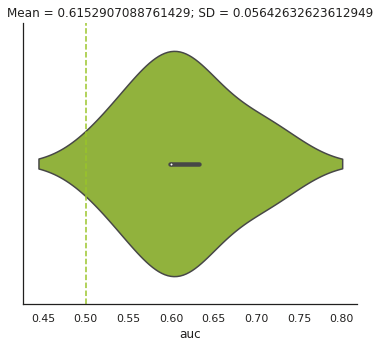

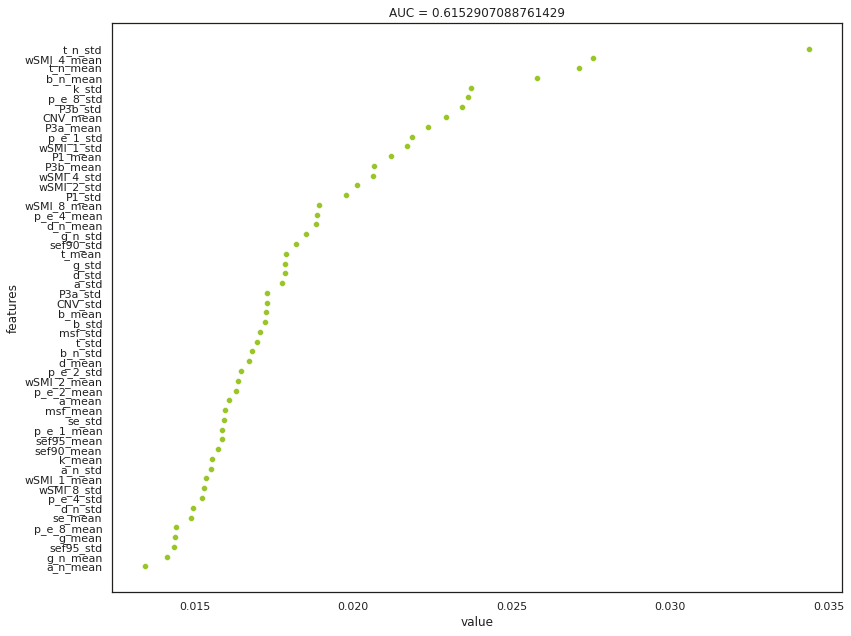

In [60]:
selected_markers = [i+'_std' for i in markers] + [i+'_mean' for i in markers] 

df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[selected_markers].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = False, n_permutations = 1000)

## Spectral

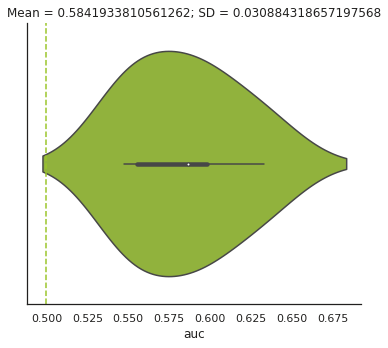

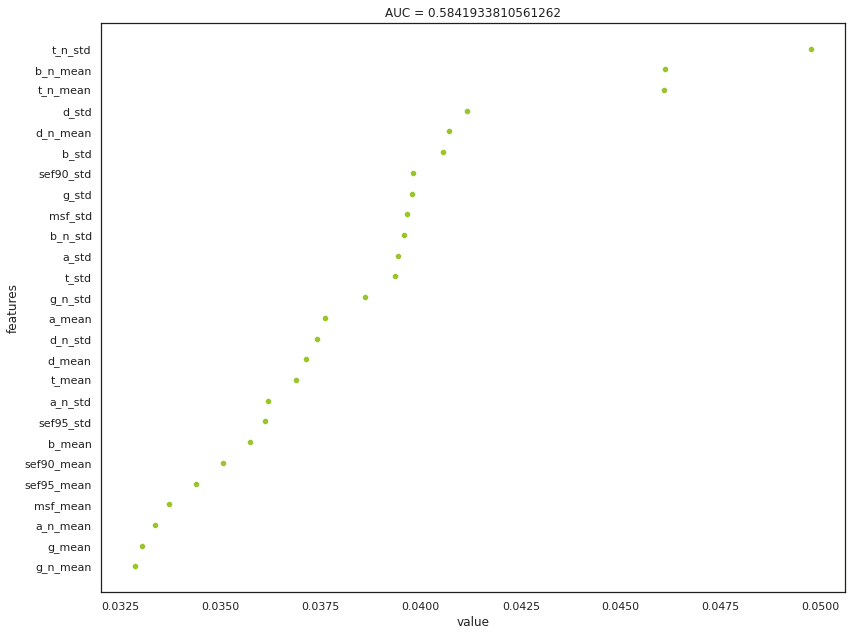

p_value = 0.07292707292707293


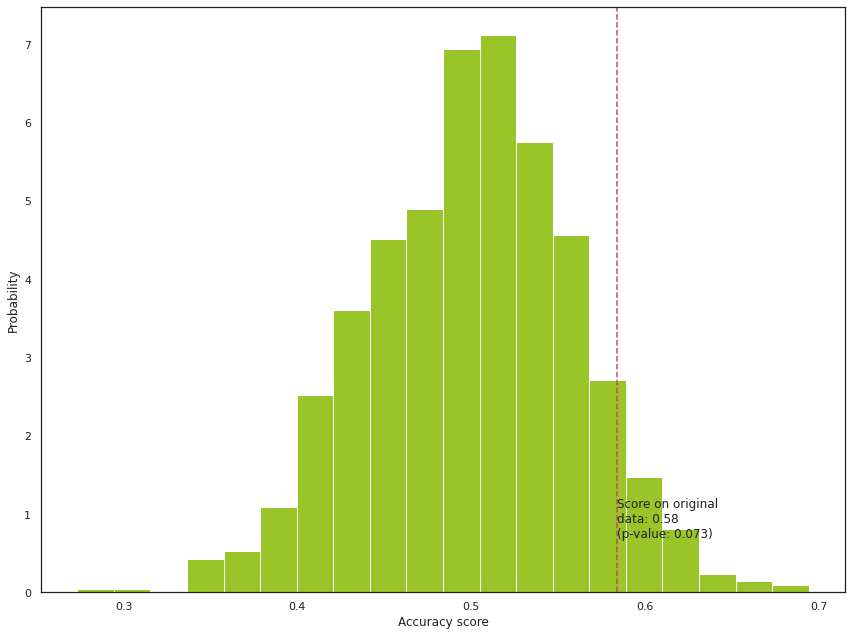

In [64]:
selected_markers = [i+'_mean' for i in spectral] + [i+'_std' for i in spectral]

df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[selected_markers].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = True, n_permutations = 1000)

### Freqs

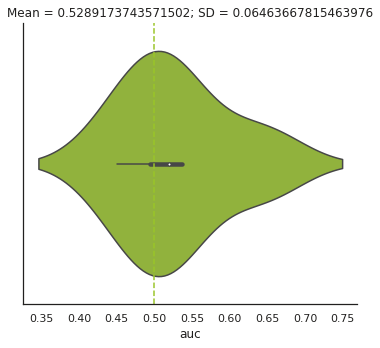

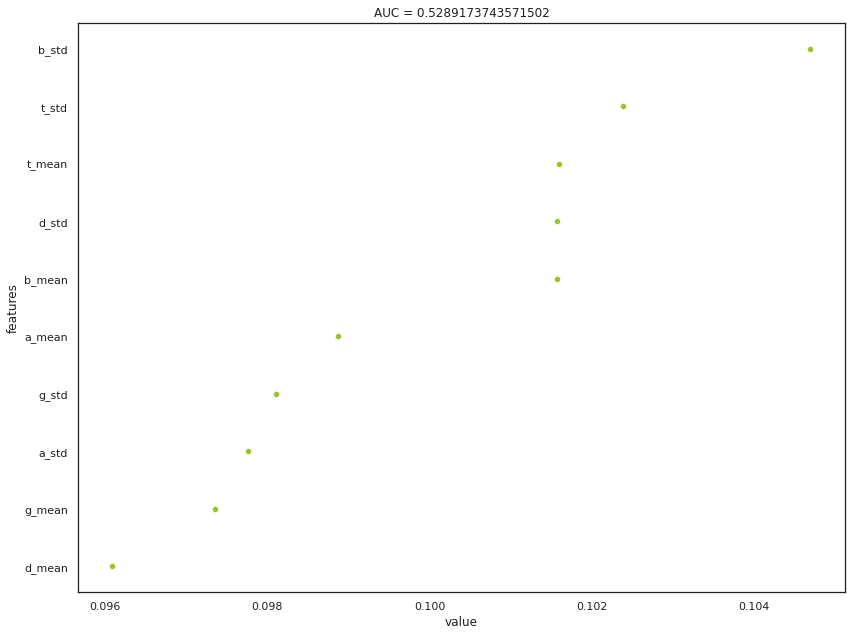

p_value = 0.3126873126873127


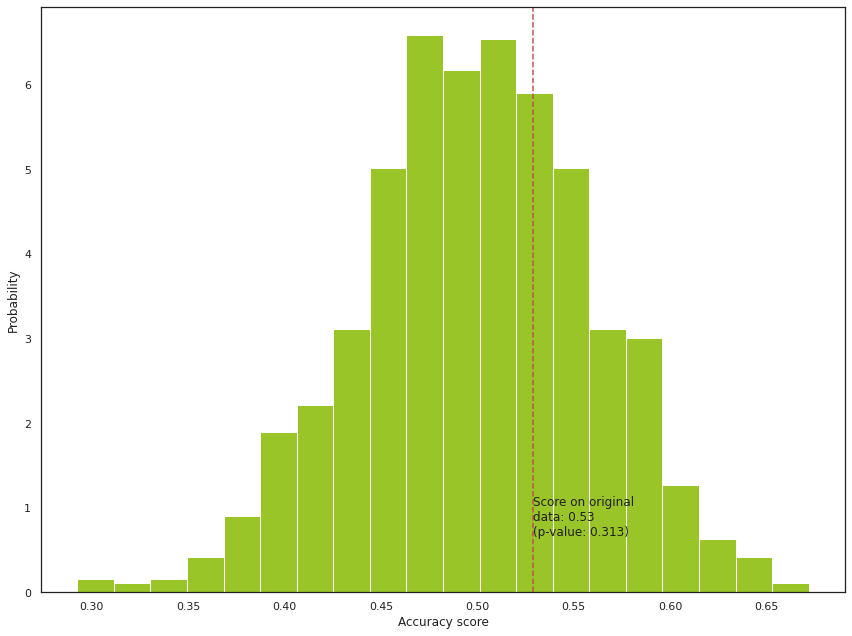

In [65]:
selected_markers = [i+'_std' for i in freqs] + [i+'_mean' for i in freqs] 

df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[selected_markers].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = True, n_permutations = 1000)

### Freqs Normalized

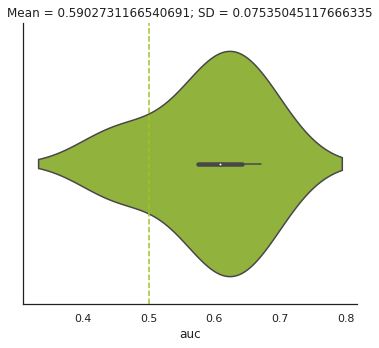

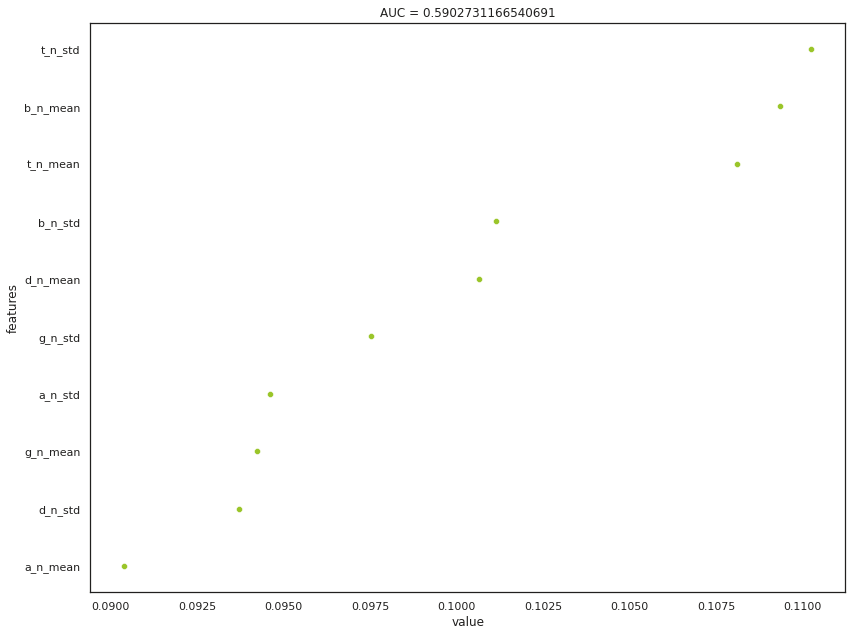

p_value = 0.07192807192807193


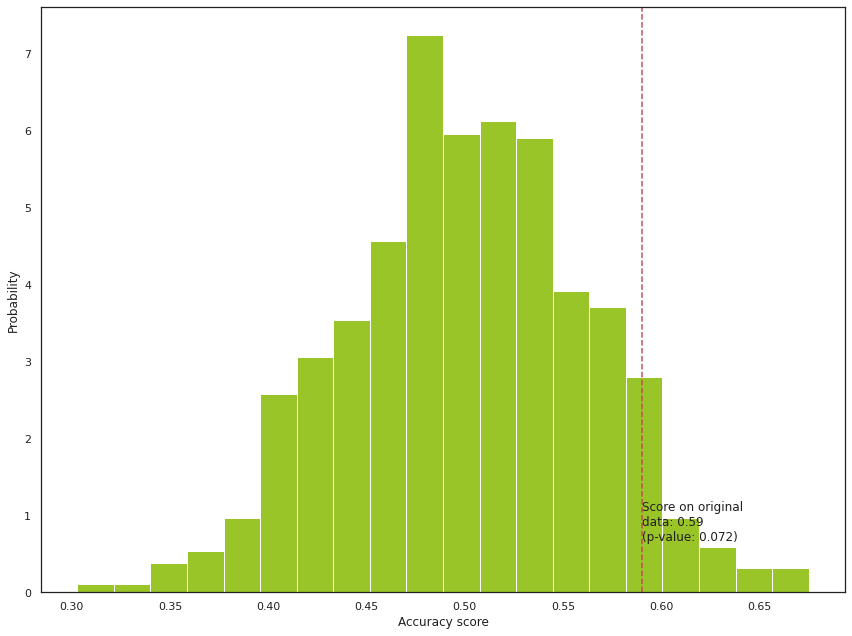

In [66]:
selected_markers = [i+'_mean' for i in freqs_n] + [i+'_std' for i in freqs_n]

df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[selected_markers].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = True, n_permutations = 1000)

### Spectral Summary

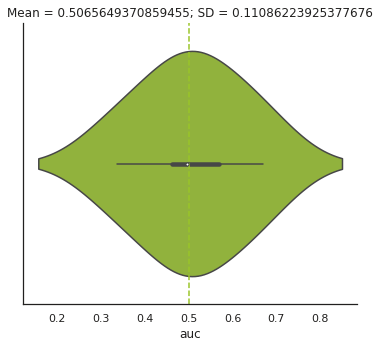

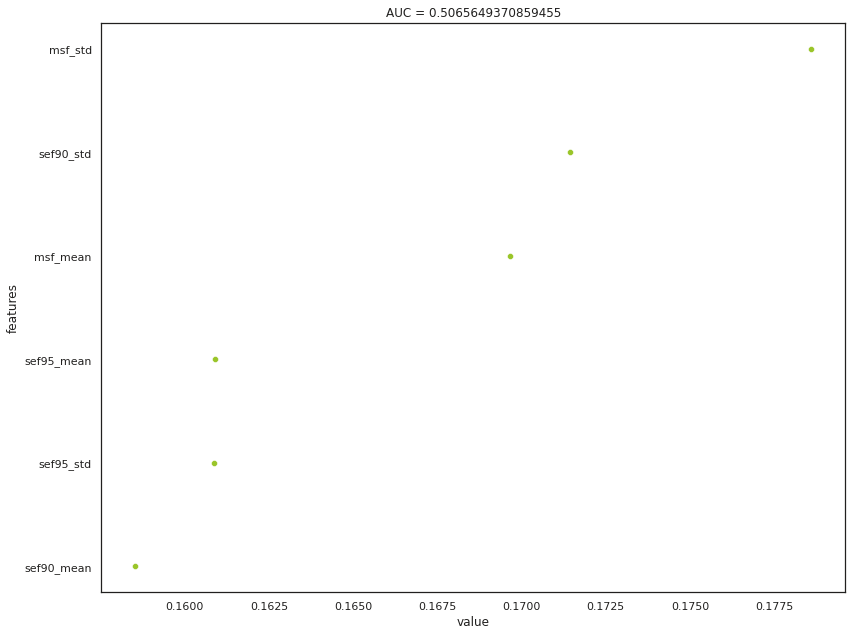

p_value = 0.44155844155844154


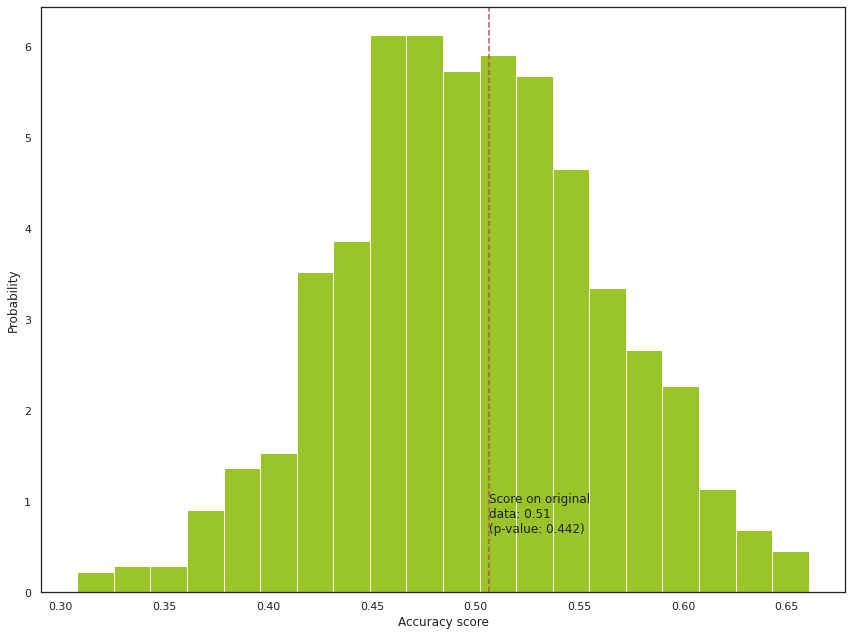

In [67]:
selected_markers = [i+'_mean' for i in spectral_summary] +[i+'_std' for i in spectral_summary]

df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[selected_markers].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = True, n_permutations = 1000)

## Complexity

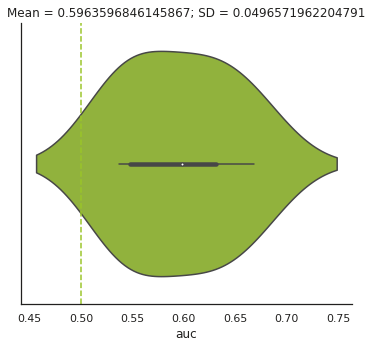

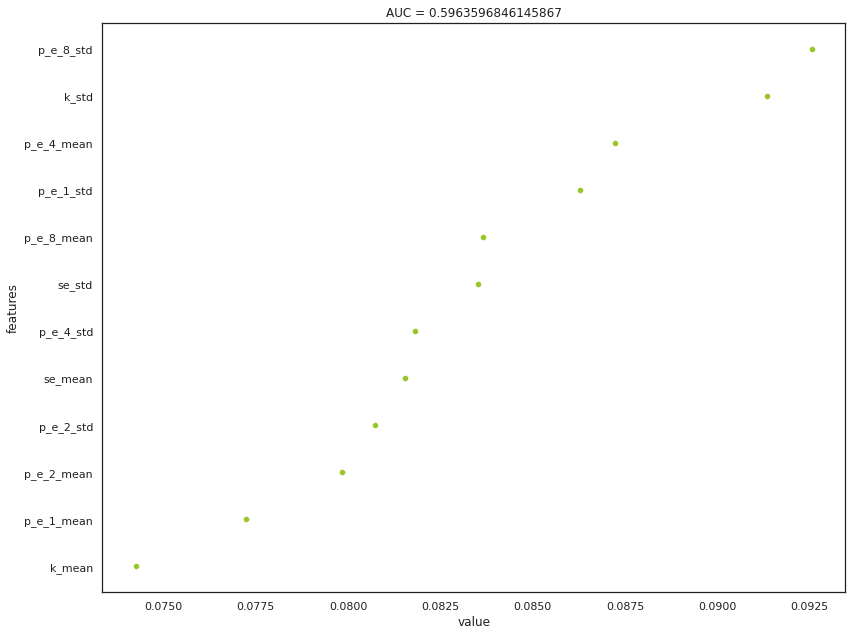

p_value = 0.054945054945054944


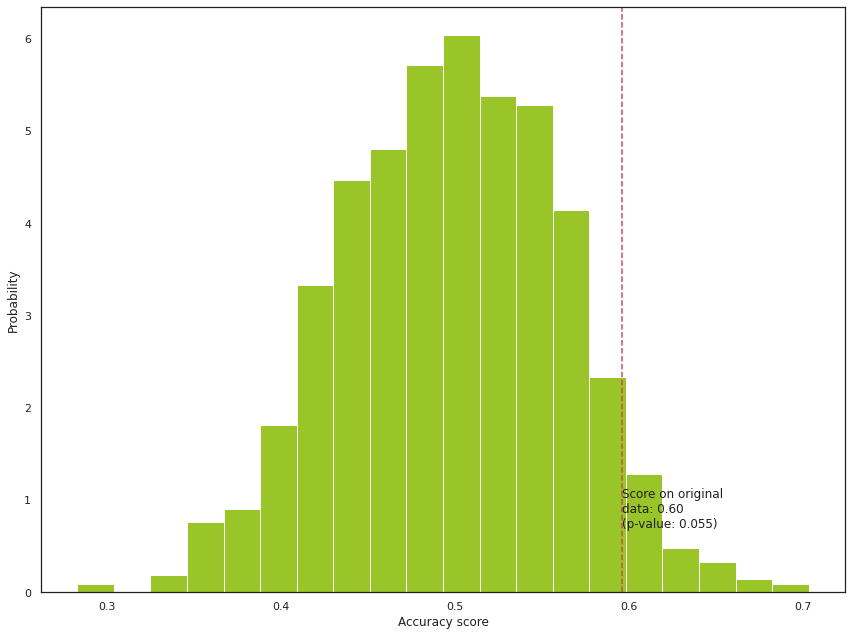

In [68]:
selected_markers = [i+'_std' for i in complexity]+[i+'_mean' for i in complexity]

df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[selected_markers].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = True, n_permutations = 1000)

## Conectivity

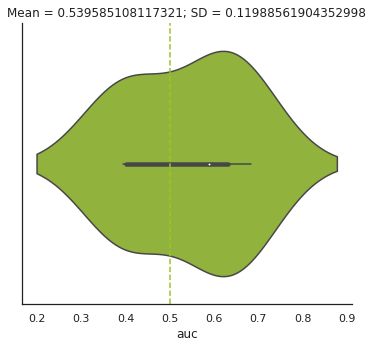

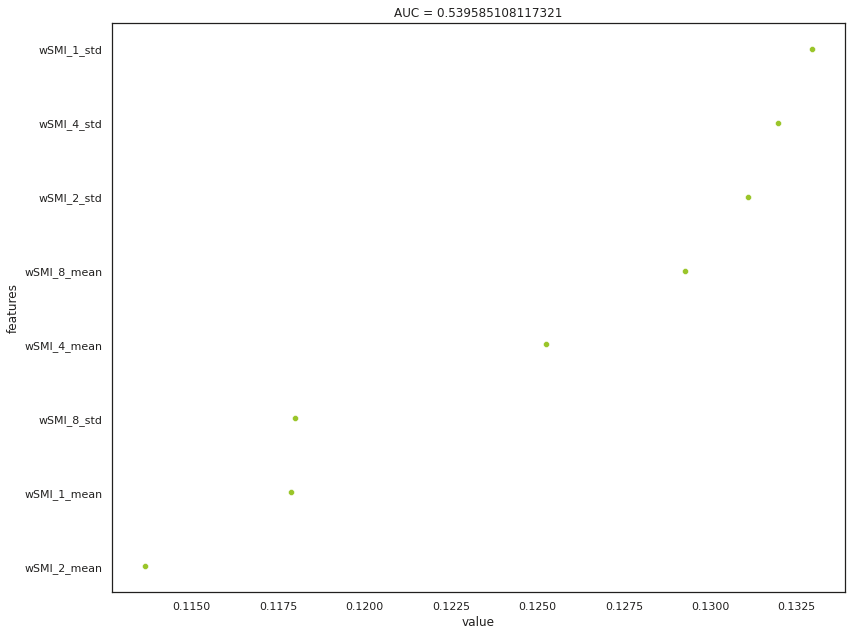

p_value = 0.25374625374625376


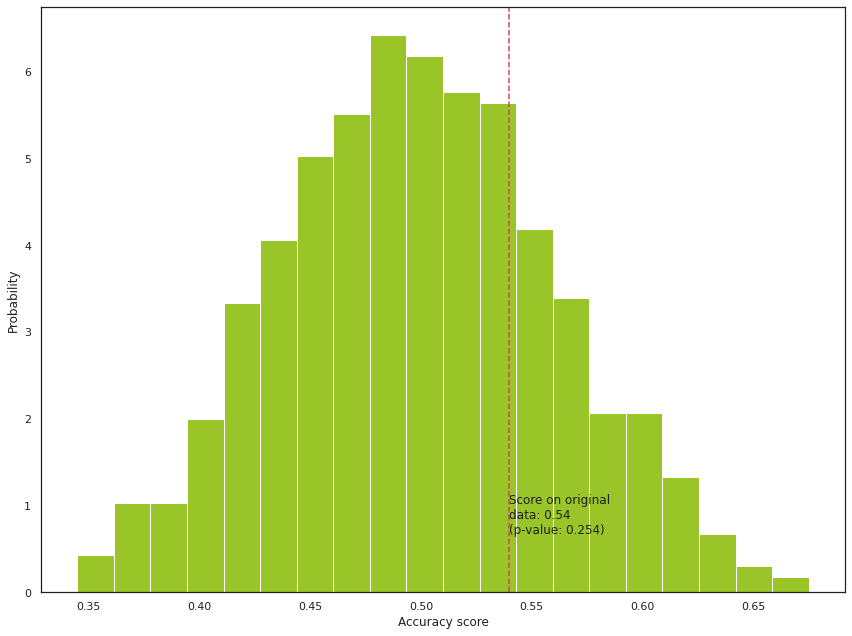

In [69]:
selected_markers = [i+'_std' for i in connectivity] + [i+'_mean' for i in connectivity] 

df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[selected_markers].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = True, n_permutations = 1000)

## ERP

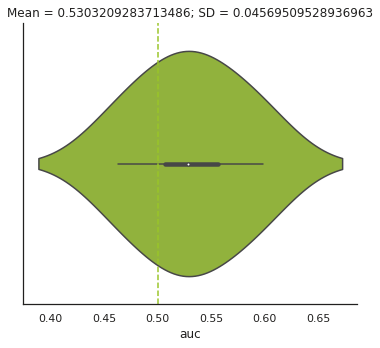

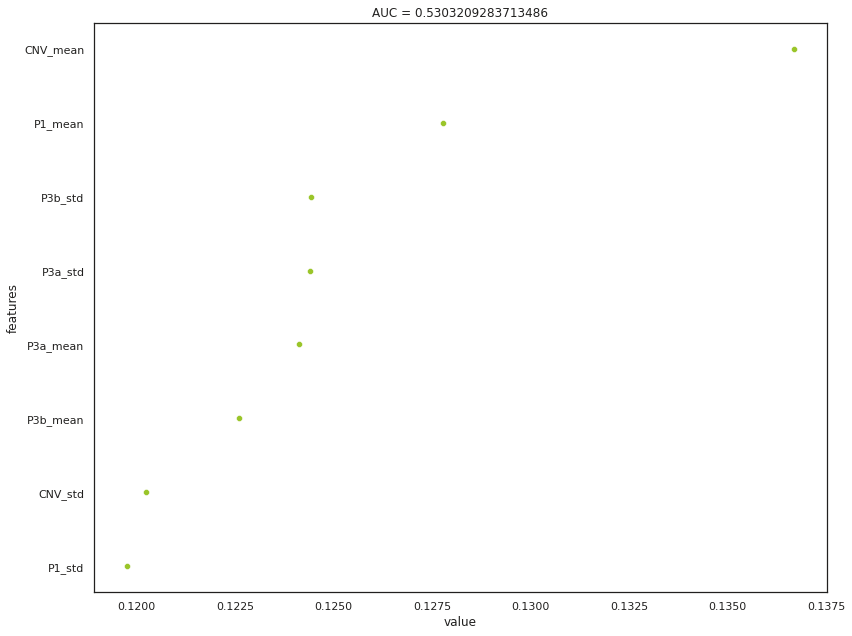

p_value = 0.3026973026973027


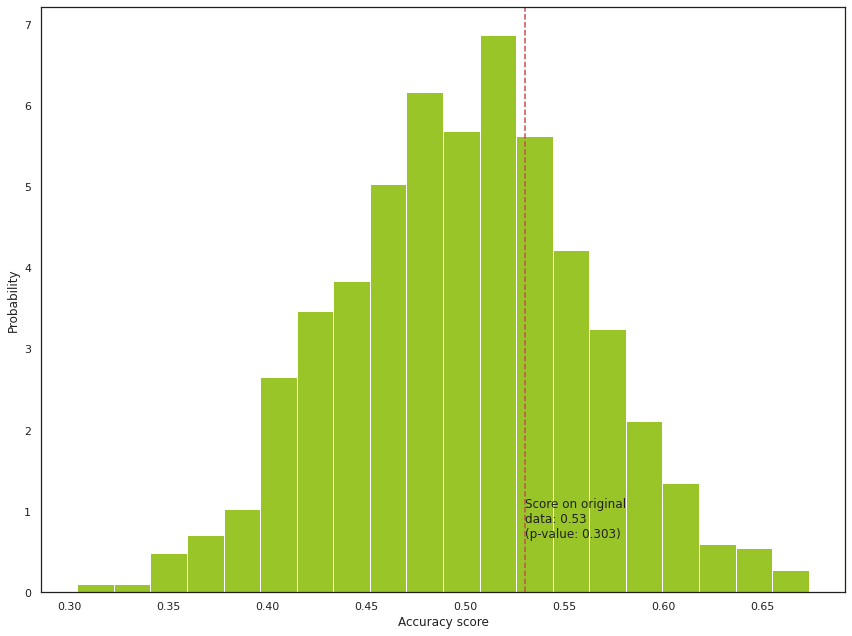

In [70]:
selected_markers = [i+'_std' for i in erps] + [i+'_mean' for i in erps] 

df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[selected_markers].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = True, n_permutations = 1000)